<a href="https://colab.research.google.com/github/WesleyKhoiVo/ViViT-action/blob/main/src/spatiotemporal/muticlass/vivit-mini-ucf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.12.0


'3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]'

In [4]:
# ! pip install opencv-python

In [5]:
import ipywidgets
import os
import io
import matplotlib.pyplot as plt
import cv2
import imageio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2 as cv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
np.random.seed(SEED)

In [6]:
# DATA
DATASET_NAME = "UCF-Crime-mini"
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (15, 100, 100, 1)
NUM_CLASSES = 13
TRAIN_RATIO = 0.7
TEST_RATIO = 0.25
VALIDATION_RATIO = 0.05

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [7]:
ROOT_PATH = "/content/drive/My Drive/ucf-crime-mini/dataset"

Abuse_PATH = ROOT_PATH + '/Abuse'
Arrest_PATH = ROOT_PATH + '/Arrest'
Assault_PATH = ROOT_PATH + '/Assault'
Burglary_PATH = ROOT_PATH + '/Burglary'
Fighting_PATH = ROOT_PATH + '/Fighting'
Normal_PATH = ROOT_PATH + '/normal'

OUT_PATH = "/content/drive/My Drive/out/vivit-ucf-mini/"

In [8]:
def extract_frames(directory, dimensions=(INPUT_SHAPE[1], INPUT_SHAPE[2]), packet_length = INPUT_SHAPE[0], save_dir_path = None):
    data = []

    for video_name in os.listdir(directory):
        video = cv2.VideoCapture(directory + '/' + video_name)
        packet = np.zeros((packet_length,)+dimensions)
        count = 0
        while video.isOpened():
            ret, frame = video.read()

            if not ret: # no more frames
                break

            del ret

            # capturing the frame

            frame = cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            packet[count] = frame
            count = count + 1
            del frame

            if count == packet_length:
                '''
                consecutive packets share 14 of the 15 frames to generate more data
                '''
                # packet itself is not normalized
                stacked = np.array(packet) # convert to numpy and normalize packet
                data.append(stacked.copy()) # this .copy() is not in the original code
                # del packet
                half_packet = packet[int(packet_length / 2 + 1):]
                packet = np.zeros((packet_length,)+dimensions)
                packet[:int(packet_length / 2)] = half_packet
                count = 7


        video.release()
        cv2.destroyAllWindows()

    del packet
    data = np.stack(data, axis= 0)

    # save to disk
    if(save_dir_path is not None):
        np.save(f'{save_dir_path}/data', data)

    return data

In [9]:
normal_frames   = extract_frames(Normal_PATH)
fighting_frames = extract_frames(Fighting_PATH)
print(normal_frames.shape)

(2400, 15, 100, 100)


In [10]:
all_frames = {
    'normal'  :normal_frames,
    'fighting':fighting_frames,
}
min_frames = np.inf

for _ ,v in all_frames.items():
    if v.shape[0] < min_frames:
        min_frames = v.shape[0]

print(min_frames)

for k, _ in all_frames.items():
    all_frames[k] = all_frames[k][:min_frames]

2400


In [11]:
all_labels = {}
count = 0
for k,v in all_frames.items():
    all_labels[k] = np.full((v.shape[0]),count)
    count = count + 1

In [12]:
train_size = int(min_frames * 0.7)
val_size   = int(min_frames * 0.75)
# test_size  = int(min_frames * 0.25)

train_frames = {}
train_labels = {}
val_frames   = {}
val_labels   = {}
test_frames  = {}
test_labels  = {}

for k, v in all_frames.items():
    train_frames[k] = v[:train_size]
    train_labels[k] = all_labels[k][:train_size]

    val_frames[k]   = v[train_size:val_size]
    val_labels[k]   = all_labels[k][train_size:val_size]

    test_frames[k]  = v[val_size:]
    test_labels[k]  = all_labels[k][val_size:]

X_train = train_frames['normal']
y_train = train_labels['normal']
X_val   = val_frames['normal']
y_val   = val_labels['normal']
X_test  = test_frames['normal']
y_test  = test_labels['normal']

for k, v in all_frames.items():
    if k == 'normal':
        continue
    X_train = np.concatenate((X_train,train_frames[k]))
    y_train = np.concatenate((y_train,train_labels[k]))

    X_test  = np.concatenate((X_test, test_frames[k]))
    y_test  = np.concatenate((y_test, test_labels[k]))

    X_val   = np.concatenate((X_val, val_frames[k]))
    y_val   = np.concatenate((y_val, val_labels[k]))

In [13]:
del all_frames, all_labels, train_frames, train_labels, test_frames, test_labels, val_frames, val_labels

In [14]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val  ,return_counts=True))
print(np.unique(y_test ,return_counts=True))

(array([0, 1]), array([1680, 1680]))
(array([0, 1]), array([120, 120]))
(array([0, 1]), array([600, 600]))


(-0.5, 99.5, 99.5, -0.5)

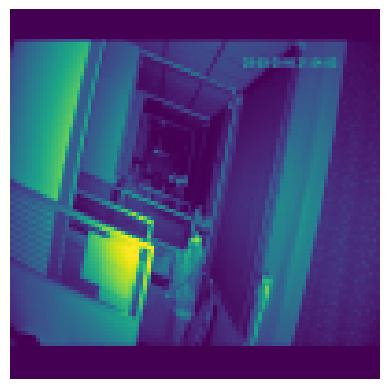

In [15]:
plt.imshow(normal_frames[0][1])
plt.axis('off')

# Data split

In [24]:
import gc
for i in range(5):
    gc.collect()

In [25]:
print( X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(3360, 15, 100, 100) (1200, 15, 100, 100) (240, 15, 100, 100) (3360,) (1200,) (240,)


0 (3360, 15, 100, 100)


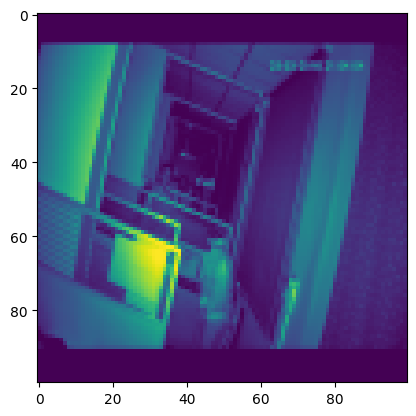

In [26]:
print(y_train[3], X_train.shape)
plt.imshow(X_train[3][0])
plt.show()

In [27]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [28]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels,
                 to_fit=True, batch_size=128, dim=(15, 100, 100),
                 n_channels=1, n_classes=13, shuffle=True):
        self.list_IDs = list_IDs
        self.labels = labels
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_grayscale_image(self.image_path + self.labels[ID])

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = self._load_grayscale_image(self.mask_path + self.labels[ID])

        return y
training_generator = DataGenerator(X_train, y_train)
validation_generator = DataGenerator(X_val, y_val)

In [29]:
len(training_generator)

26

In [30]:
X_val.shape, y_train.shape

((240, 15, 100, 100), (3360,))

In [31]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


In [32]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


In [33]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [34]:
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/checkpoints/vivit-mini-ucf/weights.{epoch:02d}.hdf5",
                monitor='val_loss',
                save_weights_only=True,
                save_best_only=True)

In [35]:
gc.collect()

3130

In [36]:
def run_experiment():
    mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/cpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    with mirrored_strategy.scope():
    # Initialize model
        model = create_vivit_classifier(
            tubelet_embedder=TubeletEmbedding(
                embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
            ),
            positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
        )

        # Compile the model with the optimizer, loss function
        # and the metrics.
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )

        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')

        # Train the model.
        history = model.fit(X_train,y_train, epochs=EPOCHS, validation_data=(X_val,y_val), callbacks=[model_checkpoint,early_stopping])

        # _, accuracy, top_5_accuracy = model.evaluate(testloader)
        # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
        # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model, history


model, history = run_experiment()

Epoch 1/60
105/105 [==============================] - 179s 2s/step - loss: 0.4502 - accuracy: 0.7810 - top-5-accuracy: 0.9982 - val_loss: 0.3632 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 2/60
105/105 [==============================] - 154s 1s/step - loss: 0.3092 - accuracy: 0.8795 - top-5-accuracy: 1.0000 - val_loss: 0.7370 - val_accuracy: 0.5542 - val_top-5-accuracy: 1.0000
Epoch 3/60
105/105 [==============================] - 155s 1s/step - loss: 0.1919 - accuracy: 0.9432 - top-5-accuracy: 1.0000 - val_loss: 0.5759 - val_accuracy: 0.5542 - val_top-5-accuracy: 1.0000
Epoch 4/60
105/105 [==============================] - 155s 1s/step - loss: 0.0362 - accuracy: 0.9964 - top-5-accuracy: 1.0000 - val_loss: 1.7678 - val_accuracy: 0.5542 - val_top-5-accuracy: 1.0000


In [39]:
model = create_vivit_classifier(
    tubelet_embedder=TubeletEmbedding(
        embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
    ),
    positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
)

# Compile the model with the optimizer, loss function
# and the metrics.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

model.load_weights("/content/drive/My Drive/checkpoints/vivit-mini-ucf/weights.01.hdf5")

Text(0.5, 0, 'Epochs ')

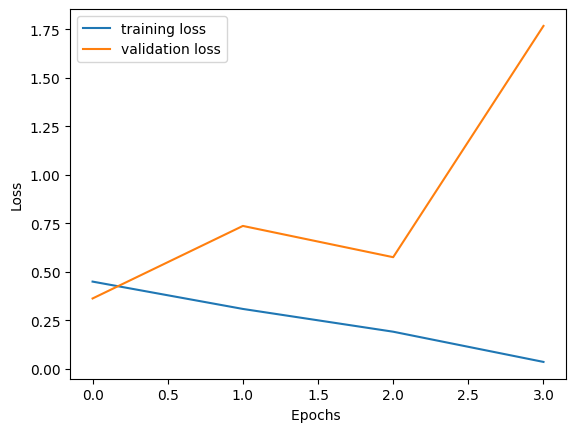

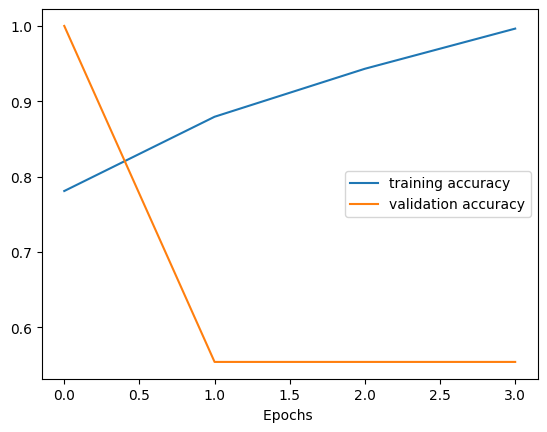

In [40]:
num=len(history.history['loss'])

plt.plot(range(num),history.history['loss'],label = 'training loss')
plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

plt.legend()

plt.xlabel("Epochs ")
plt.ylabel('Loss')

plt.figure()

plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

plt.legend()
plt.xlabel("Epochs ")

In [41]:
model.evaluate(X_val,y_val)

8/8 [==============================] - 23s 47ms/step - loss: 0.3632 - accuracy: 1.0000 - top-5-accuracy: 1.0000


[0.3631703555583954, 1.0, 1.0]

In [42]:
model.evaluate(X_test,y_test)


38/38 [==============================] - 1s 38ms/step - loss: 0.8115 - accuracy: 0.7908 - top-5-accuracy: 1.0000


[0.8114561438560486, 0.7908333539962769, 1.0]

In [43]:
from sklearn.metrics import f1_score, classification_report

y_pred = np.argmax(model.predict(X_test),axis=-1)
f1_score(y_test, y_pred, average='micro')

target_names = [
    "normal",
    #"abuse",
    #"arrest",
    #"assault",
    #"burglary",
    "fighting",
]


print(classification_report(y_test, y_pred, target_names=target_names))

38/38 [==============================] - 3s 40ms/step
              precision    recall  f1-score   support

      normal       1.00      0.58      0.74       600
    fighting       0.71      1.00      0.83       600

    accuracy                           0.79      1200
   macro avg       0.85      0.79      0.78      1200
weighted avg       0.85      0.79      0.78      1200



In [44]:
! pip install seaborn

In [47]:
np.save("/content/drive/My Drive/out/vivit-ucf-mini/y_train",y_train)
np.save("/content/drive/My Drive/out/vivit-ucf-mini/y_test",y_test)
np.save("/content/drive/My Drive/out/vivit-ucf-mini/y_val",y_val)
np.save("/content/drive/My Drive/out/vivit-ucf-mini/y_pred",y_pred)

np.save("/content/drive/My Drive/out/vivit-ucf-mini/X_train",X_train)
np.save("/content/drive/My Drive/out/vivit-ucf-mini/X_test",X_test)
np.save("/content/drive/My Drive/out/vivit-ucf-mini/X_val",X_val)


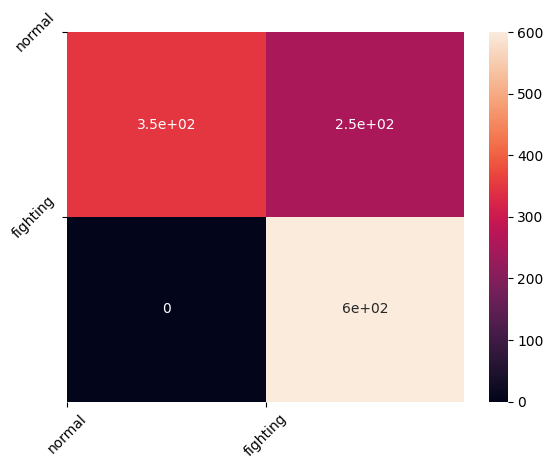

In [53]:
y_pred = np.load("/content/drive/My Drive/out/vivit-ucf-mini/y_pred.npy")
y_test = np.load("/content/drive/My Drive/out/vivit-ucf-mini/y_test.npy")
classes = ['normal','fighting']
conf = cm(y_test,y_pred)


sns.heatmap(conf,annot=True)
plt.xticks(np.arange(2),classes,rotation=45)
plt.yticks(np.arange(2),classes,rotation=45)
plt.show()